## Lab 2: Linear Regression

Linear Regression attempts to predict a continuous outcome feature (**Y**) from one or more explanatory features (**X**).  


$$Y = \beta_0 + \beta_1 X$$

$\beta_0$ is called the intercept term, and represents the expected mean value of Y when all explanatory features equal 0.  
$\beta_1$ is called a beta coefficient, and represents the expected change in the value of Y that results from a one unit change in X.  


Below is an example of a linear regression with only one explanatory feature. The red dots indicate the actual data, and the blue line represents the predicted **Y** values based on the provided **X** values.  $\beta_0$ appears to equals 0, and $\beta_1$ appears to equal 2.
<img src="../images/SimpleLinearRegression.png" alt="Drawing" style="width: 500px;height=500"/>

In this lab, we will attempt to construct a linear regression in order to answer a question that Kiva borrowers may have: 

**Does the percentage of female borrowers impact the loan amount? **

To ensure that our linear regressor is appropriate, we will have to confirm the following assumptions are not violated:
  1. Linear relationship between x and y
  2. Normality 
  3. Minimal multicollinearity (if multiple variables)
  4. No autocorrelation 
  5. Homoscedasticity 
  - Additional rule of thumb: at least 20 observations per independent variable in the analysis


Here's a look ahead at what we'll be doing in this notebook: 

1. [Load Data and Packages](#loaddata)   
  1.1 Load python packages  
  1.2 Set jupyter notebook preferences  
  1.3 Load data
    
2. [Build Linear Regression](#regressor)

3. [Define and Check Assumptions Required for Implementing a Linear Regression (listed above)](#assumptions)

4. [Model Interpretation and Validation](#interpretation)

###### NOTE: **If you haven't already, please run through previous notebooks!**  You need the final ouput df_abridged.csv.

## 1. Import packages
<a id='loaddata'></a>

In [81]:
# 1.1 Load python packages
from ggplot import *
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,8))
%matplotlib inline

import pandas as pd
import numpy as np

# packages for checking assumptions
from scipy import stats as stats
import statsmodels.formula.api as sm
from sklearn.model_selection import train_test_split

In [3]:
# 1.2 Set jupyter notebook preferences
# the command below means that the output of multiple commands in a cell will be output at once.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# the command below tells jupyter to display up to 100 columns, this keeps everything visible
pd.set_option('display.max_columns', 100)
pd.set_option('expand_frame_repr', True)

In [4]:
# 1.3 Load Data
data_path = '../../data/'
df = pd.read_csv(data_path+'df_abridged.csv', low_memory=False)

## 2. Build Linear Regression
<a id="regressor"></a>

Prior to building our model, we first need to split our dataset into a training set and a test set.  We will use our training set to trian our regressor, and we will use our test set for model validation.
To achieve this, we will use call sklearn's [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html), and set the input parameter `test_size` to .2 so that 20% of the data will be assigned to the test set and 80% of the data will be assigned to the training set.

In [82]:
X = df[['pct_female']]
y = df['loan_amount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In order to build our linear regressor, we will use [statsmodels](http://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.html) implementation.  The are other implementations out there; however, we will use statmodels because it creates a nice summary table for model evaluation.  We will not evaluate the results of the fitted model until after we confirm that none of the assumptions have been violated, but for now let's print out the summary table to demonstrate how easy it is to train the model and see the results.

In [85]:
model0 = sm.OLS(endog = y,exog = X).fit()
print(model0.summary())

                            OLS Regression Results                            
Dep. Variable:            loan_amount   R-squared:                       0.340
Model:                            OLS   Adj. R-squared:                  0.340
Method:                 Least Squares   F-statistic:                 6.094e+04
Date:                Sun, 27 Aug 2017   Prob (F-statistic):               0.00
Time:                        18:20:52   Log-Likelihood:            -9.0632e+05
No. Observations:              118199   AIC:                         1.813e+06
Df Residuals:                  118198   BIC:                         1.813e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
pct_female     4.9823      0.020    246.870      0.0

## 3. Checking Assumptions
<a id='assumptions'></a>

In order for linear regression to be an appropriate model, the following assumptions must be confirmed:
  1. Linear relationship between x and y. 
  2. Normality
  3. Minimal multicollinearity 
  4. No autocorrelation
  5. Homoscedasticity 


If these assumptions are not met, the results of the linear regression model would not be useful in describing the relationship between the variables.



### Linearity
First, as the name implies, linear regression requires the underlying relationship between the independent (x) and dependent (y) variables to be linear. This means that a line drawn through the points can capture the relationship, with some degree of error. 

We must also be aware of outliers, which can throw off a linear relationship. 

The most straightforward check of linearity is to make scatter plots of the variables chosen.

[TODO: insert scatterplot of percent female and loan amouont]


### Normality

Normality means the distribution of values falls into a particular pattern. 

The normality assumption can be checked by making histograms or Q-Q (quantile-quantile) plots.

[TODO: insert histogram of distribution of X and Y]
[TODO: insert Q-Q plot of X and Y]

If a variable is not normal, it may be adjusted by a [non-linear transformation](https://stats.stackexchange.com/questions/298/in-linear-regression-when-is-it-appropriate-to-use-the-log-of-an-independent-va).

Another way to check normality is to examine the [residuals](https://www.khanacademy.org/math/statistics-probability/describing-relationships-quantitative-data/regression-library/a/introduction-to-residuals), which is the difference between the predicted and actual outcome variable.

We already know our data is skewed by outliers, however before we begin modeling let's quantify the degree to which it is skewed.

[Scipy's stats package](https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.stats.skew.html) allows you to conduct a skew test. A normally distributed dataset would return about 0. A skewness value of greater than 0 means there are more loans in the left tail of the distribution. Typically, a skew score of +-5 is deemed acceptable.


[Multivariate normality](https://en.wikipedia.org/wiki/Multivariate_normal_distribution) is a generalization of one-dimensional, or univariate, normality, to more dimensions. For a regression using multiple independent (x) variables, this means checking that all of the linear combinations of variables used are normal. 


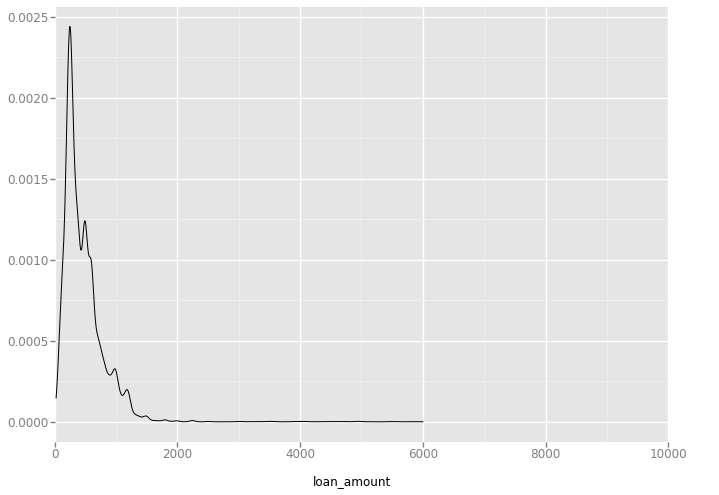

<ggplot: (298362821)>

In [91]:
ggplot(df, aes(x='loan_amount')) + geom_density() + xlim(0,10000)

In [95]:
print(stats.skew(df.loan_amount, axis=None))

5.352856533783493


This confirms our suspicion that the data is skewed to the left, i.e. the mean is smaller than the median. However, the degree to which it is skewed is not troubling. +-3 is fairly reasonable. 

If you face a dataset with more severely skewed data, we describe a way to address this in the appendix below.

### Multicollinearity

To recap Module 2's lesson, multicollinearity means that two or more explanatory features are highly correlated.

This makes it difficult for the model to try to differentiate between each feature's influence on the explanatory feature.

One way to check this is by examining the correlation matrix and making sure none of the variables correlate to 1. 

Numpy's Corrcoef function returns a matrix of Pearson correlation coefficients. 

Read more about Numpy's Corrcoef [here](https://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.corrcoef.html).

Try running different features!


In [7]:
np.corrcoef(df.loan_amount, df.funded_amount)

array([[ 1.        ,  0.94971556],
       [ 0.94971556,  1.        ]])

This tells us that loan amount and funded amount are extremely highly correlated - a vast majority of loans requested get funded! Normally, we would be interested in both loan_amount and funded_amount as an outcome feature, but here we see that it would be redundant to test both. 

It would take a long time for us to test each and every relationship between two sets of variables, so let's create a correlation matrix that lets us visualize every correlation in a dataset using Pandas.

In [8]:
df_corr_tbl = df[['loan_amount','partner_loans_posted', 'posted_month', 'partner_delinquency_rate']]
df_corr_tbl.corr()

,loan_amount,partner_loans_posted,posted_month,partner_delinquency_rate
loan_amount,1.000000,-0.201286,-0.020265,0.012336
partner_loans_posted,-0.201286,1.000000,0.004283,0.315862
posted_month,-0.020265,0.004283,1.000000,0.008193
partner_delinquency_rate,0.012336,0.315862,0.008193,1.000000


Of course, not every correlation in this table will be meaningful. A correlation table is useful as it provides a visual shortcut to see what relationships might be problematic for multicollinearity. It appears we have no issues with collinearity.

### No autocorrelation

A variable has autocorrelation when values in the series correlate with others in the same series, separated by a given interval.

In terms of the residuals, this means checking that residuals are independent.

A check for this could be the Durbin-Watson test. 



### Homoscedasticity

Homoscedasticity is a statistical term that means that the spread of the residuals are equal across the regression line. 

This assumption means that the variance around the regression line is the same for all values of the predictor variable (X). 

In order to test for homoscedasticity, we will first have to calculate the studentized residuals by using the built in [outlier_test](http://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLSResults.outlier_test.html)

In [86]:
residuals = model0.outlier_test()['student_resid']

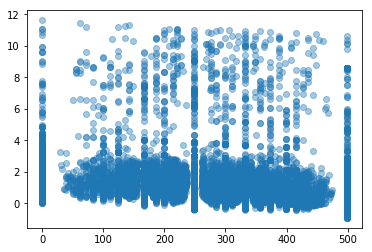

In [89]:
y_hats = model0.predict(X)
plt.scatter(y_hats, residuals, alpha = .4)

## 4. Model Interpretation and Validation
<a id="interpretation"></a>

Now we have two separate datasets: train_set and test_set. We will run the regression on train_set
using statsmodel's "ols" function. Let's try a simple example to start: 

In [10]:
model0 = sm.ols(formula="loan_amount ~ gender", data=train_set).fit()
print(model0.summary()) 

                            OLS Regression Results                            
Dep. Variable:            loan_amount   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     900.2
Date:                Sun, 27 Aug 2017   Prob (F-statistic):          7.32e-197
Time:                        13:41:10   Log-Likelihood:            -7.0426e+05
No. Observations:               94559   AIC:                         1.409e+06
Df Residuals:                   94557   BIC:                         1.409e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        452.3568      1.655    273.

This is the typical regression output. It's a lot to digest! Remember that our simple model can be represented as a linear equation, like this: 

    loan_amount = intercept + coef*male

Therefore, these results can be translated as follows: 

    loan_amount = 424.30 + 110.90*male
    
Let's state the results. Regardless of gender the predicted loan amount is 424 dollars. However, if the lender is a man the loan amount increases by 110 dollars. This is consistent with our earlier explanatory analysis. How do we know however, whether this is a significant result?

We have a sufficient amount of confidence in this conclusion because the **p-value** is reported to be 0.000. In technical terms, the p-value is **the probability of getting results as extreme as the ones observed. **

In statistics, we want our results to fall within the 95% confidence interval, or the p-value to be <= 0.05. This means, "[i]f repeated samples were taken and the 95% confidence interval was computed for each sample, 95% of the intervals would contain the population mean. A 95% confidence interval has a 0.95 probability of containing the population mean. 95% of the population distribution is contained in the confidence interval." [Read more here.](http://www.investopedia.com/terms/s/standard-error.asp) The p-value is an indicator of where we fall in the confidence interval. In English, small p-value (<= 0.05) indicates strong evidence that the coefficient is different than 0. 

This is a relatively simplified explanation of p-values. Don't worry if it's not immediately intuitive - [not even professional statisticians can easily explain this concept.](http://fivethirtyeight.com/features/not-even-scientists-can-easily-explain-p-values/) To get a deeper understanding, we recommend grabbing the nearest textbook on statistics to review! 

Note also that the Adjusted R Squared is extremely low. To recap lessons from Module 2, the Adjusted R Squared is an explanation of how much of the outcome feature can be explained by the model's explanatory features. This low Adj R Squared suggests that the predictive value of male is pretty low - it cannot be used as the single feature to predict loan_amount. 

This result is in line with our understanding of the world - there must be other factors influencing loan_amount. Let's try complicating the model by adding more explanatory features. **But which ones?**

In [ ]:
to add:
    1. ridge regression
    2. stepwise regression

## Appendix A.
## Additional context on how to deal with skewed data:
<a id="skewed"> </a>


One potential solution is to **log transform** your data. For a quick review of logarithms, look [here](https://www.mathsisfun.com/algebra/logarithms.html). 

Note that when we log transform data, we change our interpretation of the final regression output. Previously we had a simple linear equation... 

    y = mx + b

This could be interpreted as, with every unit increase in x, we get a m increase in outcome feature y. Now we have a log equation: 

    log(y) = mx + b
    
This is less intuitive, as we have to solve for y. When we solve for y through exponentiation, we get the following equation: 

    y = 10^(mx + b)
    y = 10^(mx) * 10^(b)

The default base for log is 10. The takeaway here is that the impact x would have on y is much larger than linear - it is **exponentiated**. We will return to this interpretation in the discussion of the linear regression model. Let's try log transforming our loan_amount variable. 

## Homework

Choose three other features you think might influence loan amount. Interpret the results by writing a statement like the one below that we wrote to understand the relationship with gender:

"Regardless of gender the predicted loan amount is 424 dollars. However, if the lender is a man the predicted loan amount increases by 110 dollars." 


### Univariate Regression 1

### Univariate Regression 2

### Univariate Regression 3

## Advanced Homework (Optional)

Multivariate regression is where there are multiple explanatory variables. Below is a code template for you to start playing with a multivariate model. Interpret your results.

In [ ]:
model1 = sm.ols(formula="[replace with the name of your outcome feature] ~[replace with the name of your explantory variable 1]  + [replace with the name of your explantory variable 1] +[replace with the name of your explantory variable 1] +", data=train_set)
model1_results = model1.fit()
print(model1_results.summary())

## Multivariate Regression

In [ ]:
model1 = sm.ols(formula="log_loan_amount ~ borrower_count + sector + kids + gender + widowed + pictured + video + posted_year +\
                days_to_expire + repayment_term + partner_profitability + eco_friendly + animals + elderly + technology", data=train_set)
model1_results = model1.fit()
print(model1_results.summary())

This **multi-feature** (or multivariate) model is more aligned with our understanding of the world. Most coefficients have very low p-values - a good sign! 

Our Adjusted R Squared is higher than it was in the single-feature model. Let's get into how we evaluate the model in terms of predictiveness. 

## Model Validation

<i>How can we evaluate how our model is doing? </i>

In the previous section, we were able to get general ideas of how well our model was doing by using metrics like Adjusted R Squared, coefficients, and p-value. However, the goal of most machine learning is a model that can <b>predict outcome features accurately</b>. Recall that we randomly split our dataset into a training set (80%) and a test set (20%). Now we will use the results from the regression conducted on our training set to predict the outcome features for each observation in our test set. The difference between the predicted outcome feature and the actual outcome feature for each observation gives us an idea of how close we are to the mark.  

In the previous section, we used the **statsmodel** package in order to output a regression output table. Now, we run the regression using the **scikit-learn** package, which is optimized specifically for machine learning and allows us to validate our models easily. Remember this package - we will be returning to it for the rest of the class!  

## Model Validation using scikit learn

In order to use scikit-learn to run a regression, we format the data differently than how we do when we use statsmodels. 

In scikit-learn, we want to make sure: 
1. Categorical features are converted Booleans with values of either 1 or 0
2. Data is separated into two separate and clean datasets: x and y, or explanatory features and outcome feature. 

We do this below in the pre-processing section.

## Next Steps

Next monday, we will go over your results and well as show you what we did for the multivariate regression. Next, we move on to a new algorithm (decision trees). Very exciting!